<a href="https://colab.research.google.com/" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Retropropagación en red densa

Programa el algoritmo de retropropagación usando NumPy para una tarea de clasificación binaria presuponiendo una red densa con dos capas ocultas. Esta red tiene una función de activación logística en todas sus neuronas y se entrena minimizando la función de pérdida de entropía cruzada binaria. Describe las fórmulas y reglas de actualización de los pesos y sesgos de cada capa y entrena y evalúa la red en algún conjunto de datos.

In [ ]:
import os
import numpy as np
import pandas as pd

La red neuronal densa está compuesta por una capa de $m$ entradas, dos capas ocultas de $n$ neuronas con función de activación sigmoide y una capa de salida de una sola neurona con función de activación sigmoide. La función de activación se define de la siguiente manera:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [ ]:
def sigm(z):
    return 1 / (1 + np.exp(-z))

La función sigmoide tiene una derivada expresada en términos de si misma: 

$$
\frac{\partial \sigma (z)}{\partial z} = \sigma(z) (1 - \sigma(z))
$$

In [ ]:
def deriv_sigm(z):
    return np.multiply(sigm(z), (1.0 - sigm(z)))

Como se trabajará con una clasificación binaria y las neuronas tienen funciones de activación logística, se usará la función de pérdida de entropía cruzada binaria:

$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

In [ ]:
def ECB(y, y_hat):
    y_hat[y_hat == 0.] = np.nextafter(0, 1)
    y_hat[y_hat == 1.] = np.nextafter(1, 0)
    return -(y * np.log(y_hat) + (1- y) * np.log(1 - y_hat)).sum()

Asimismo, se calculará la exactitud para medir el rendimiento aprendido de la red neuronal densa:

$$
exactitud = \frac{correctos}{total} * 100
$$

In [ ]:
def exactitud(y, pred):
    return (y == pred).mean() * 100

Después se define la función que propaga hacia adelante la entrada $\mathbf{x}^{i}$. La red está compuesta de 3 capas densas (2 ocultas y 1 de salida), por lo tanto se tienen 3 matrices de pesos con sus correspondientes vectores de sesgos $\{\mathbf{W}^{\{1\}}, \mathbf{b}^{\{1\}}\}$, $\{\mathbf{W}^{\{2\}}, \mathbf{b}^{\{2\}}\}$ (de las capas ocultas) y $\{\mathbf{W}^{\{3\}}, \mathbf{b}^{\{3\}}\}$ (de la capa de salida). Así, es posible hacer la propagación hacia adelante de la siguiente manera:

$$
\begin{split}
\mathbf{a}^{\{1\}} & =  \mathbf{x}^{(i)} \\
\mathbf{z}^{\{2\}} & =  \mathbf{W}^{\{1\}} \cdot \mathbf{a}^{\{1\}} + \mathbf{b}^{\{1\}}\\
\mathbf{a}^{\{2\}} & =  \sigma(\mathbf{z}^{\{2\}}) \\
\mathbf{z}^{\{3\}} & =  \mathbf{W}^{\{2\}} \cdot \mathbf{a}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
\mathbf{a}^{\{3\}} & =  \sigma(\mathbf{z}^{\{3\}})\\
\mathbf{z}^{\{4\}} & =  \mathbf{W}^{\{3\}} \cdot \mathbf{a}^{\{3\}}  + \mathbf{b}^{\{3\}}\\
\mathbf{a}^{\{4\}} & =  \sigma(\mathbf{z}^{\{4\}})\\
\hat{y}^{(i)} & =  \mathbf{a}^{\{4\}}
\end{split}
$$

In [ ]:
def adelante(x, W1, b1, W2, b2, W3, b3):
    z2 = np.dot(W1.T, x[:, np.newaxis]) + b1
    a2 = sigm(z2)
    z3 = np.dot(W2.T, a2) + b2
    a3 = sigm(z3)
    z4 = np.dot(W3.T, a3) + b3
    y_hat = sigm(z4)
    return z2, a2, z3, a3, z4, y_hat

Las matrices de pesos se inicializarán con un valor pequeño de una muestra aleatoria con distribución normal: media $0$ y varianza $1$. Posteriormente, se define la función para entrenar la red neuronal densa empleando descenso por gradiente. Para calcular el gradiente de la función de pérdida respecto a los pesos y sesgos en cada capa, se utiliza el algoritmo de retropropagación. Recordar que en este caso $\hat{y} = \sigma(z^{\{4\}})$. A continuación se muestran los cálculos de los gradientes para los pesos y sesgos:



### Gradiente de la función de pérdida respecto a $W^{\{3\}}$:

$$
\frac{\partial ECB(y, \hat{y})}{\partial W^{\{3\}}} = \frac{\sum_{i=1}^{N} \partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial W^{\{3\}}} = \\
\sum_{i=1}^{N} \left(\frac{\partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial \hat{y}^{(i)}}\right) \left( \frac{\partial \hat{y}^{(i)}}{\partial z^{\{4\}}} \right) \left( \frac{\partial z^{\{4\}}}{\partial W^{\{3\}}} \right) = \\
\sum_{i=1}^{N} \left( \frac{\hat{y}^{(i)} - y}{\hat{y}^{(i)} (1-\hat{y}^{(i)})} \right) \cdot \left( \hat{y}^{(i)} (1 - \hat{y}^{(i)}) \right) \cdot \left( a^{\{3\}} \right) = \\
\sum_{i=1}^{N} \underbrace{(\hat{y}^{(i)} - y^{(i)})}_{\delta^{\{4\}}} \cdot a^{\{3\}}
$$

### Gradiente de la función de pérdida respecto a $W^{\{2\}}$:

$$
\frac{\partial ECB(y, \hat{y})}{\partial W^{\{2\}}} = \frac{\sum_{i=1}^{N} \partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial W^{\{2\}}} = \\
\sum_{i=1}^{N} \left(\frac{\partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial \hat{y}^{(i)}}\right) \left( \frac{\partial \hat{y}^{(i)}}{\partial z^{\{4\}}} \right) \left( \frac{\partial z^{\{4\}}}{\partial W^{\{2\}}} \right) = \\
\sum_{i=1}^{N} \underbrace{(\hat{y}^{(i)} - y^{(i)})}_{\delta^{\{4\}}} \cdot \frac{\partial z^{\{4\}}}{\partial W^{\{2\}}} =\\
\sum_{i=1}^{N} \delta^{\{4\}} \cdot \frac{\partial z^{\{4\}}}{\partial W^{\{2\}}} = \delta^{\{4\}} \cdot \left( \frac{\partial z^{\{4\}}}{\partial a^{\{3\}}} \cdot \frac{\partial a^{\{3\}}}{\partial W^{\{2\}}} \right) =\\
\sum_{i=1}^{N} \delta^{\{4\}} \cdot W^{\{3\}} \cdot \frac{\partial a^{\{3\}}}{\partial W^{\{2\}}} = \delta^{\{4\}} \cdot W^{\{3\}} \cdot \left( \frac{\partial a^{\{3\}}}{\partial z^{\{3\}}} \cdot \frac{\partial z^{\{3\}}}{\partial W^{\{2\}}} \right) = \\
\sum_{i=1}^{N} \underbrace{\delta^{\{4\}} \cdot W^{\{3\}} \cdot \frac{\partial a^{\{3\}}}{\partial z^{\{3\}}}}_{\delta^{\{3\}}} \cdot a^{\{2\}}
$$

### Gradiente de la función de pérdida respecto a $W^{\{1\}}$:

$$
\frac{\partial ECB(y, \hat{y})}{\partial W^{\{1\}}} = \frac{\sum_{i=1}^{N} \partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial W^{\{1\}}} = \\
\sum_{i=1}^{N} \left(\frac{\partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial \hat{y}^{(i)}}\right) \left( \frac{\partial \hat{y}^{(i)}}{\partial z^{\{4\}}} \right) \left( \frac{\partial z^{\{4\}}}{\partial W^{\{1\}}} \right) = \\
\sum_{i=1}^{N} \underbrace{(\hat{y}^{(i)} - y^{(i)})}_{\delta^{\{4\}}} \cdot \frac{\partial z^{\{4\}}}{\partial W^{\{1\}}} =\\
\sum_{i=1}^{N} \delta^{\{4\}} \cdot \frac{\partial z^{\{4\}}}{\partial W^{\{1\}}} = \delta^{\{4\}} \cdot \left( \frac{\partial z^{\{4\}}}{\partial a^{\{3\}}} \cdot \frac{\partial a^{\{3\}}}{\partial W^{\{1\}}} \right) =\\
\sum_{i=1}^{N} \delta^{\{4\}} \cdot W^{\{3\}} \cdot \frac{\partial a^{\{3\}}}{\partial W^{\{1\}}} = \delta^{\{4\}} \cdot W^{\{3\}} \cdot \left( \frac{\partial a^{\{3\}}}{\partial z^{\{3\}}} \cdot \frac{\partial z^{\{3\}}}{\partial W^{\{1\}}} \right) = \\
\sum_{i=1}^{N} \underbrace{\delta^{\{4\}} \cdot W^{\{3\}} \cdot \frac{\partial a^{\{3\}}}{\partial z^{\{3\}}}}_{\delta^{\{3\}}} \cdot \frac{\partial z^{\{3\}}}{\partial W^{\{1\}}} = \delta^{\{3\}} \cdot \frac{\partial z^{\{3\}}}{\partial W^{\{1\}}} = \\
\sum_{i=1}^{N} \delta^{\{3\}} \cdot \left( \frac{\partial z^{\{3\}}}{\partial a^{\{2\}}} \cdot \frac{\partial a^{\{2\}}}{\partial W^{\{1\}}} \right) = \delta^{\{3\}} \cdot W^{\{2\}} \cdot \frac{\partial a^{\{2\}}}{\partial W^{\{1\}}} = \\
\sum_{i=1}^{N} \delta^{\{3\}} \cdot W^{\{2\}} \cdot \left( \frac{\partial a^{\{2\}}}{\partial z^{\{2\}}} \cdot \frac{\partial z^{\{2\}}}{\partial W^{\{1\}}} \right) = \\
\sum_{i=1}^{N} \underbrace{\delta^{\{3\}} \cdot W^{\{2\}} \cdot \frac{\partial a^{\{2\}}}{\partial z^{\{2\}}}}_{\delta^{\{2\}}} \cdot x^{(i)}
$$

### Gradiente de la función de pérdida respecto a $b^{\{3\}}$:

$$
\frac{\partial ECB(y, \hat{y})}{\partial b^{\{3\}}} = \frac{\sum_{i=1}^{N} \partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial b^{\{3\}}} = \\
\sum_{i=1}^{N} \left(\frac{\partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial \hat{y}^{(i)}}\right) \left( \frac{\partial \hat{y}^{(i)}}{\partial z^{\{4\}}} \right) \left( \frac{\partial z^{\{4\}}}{\partial b^{\{3\}}} \right) = \\
\sum_{i=1}^{N} \left( \frac{\hat{y}^{(i)} - y}{\hat{y}^{(i)} (1-\hat{y}^{(i)})} \right) \cdot \left( \hat{y}^{(i)} (1 - \hat{y}^{(i)}) \right) \cdot \left( 1 \right) = \\
\sum_{i=1}^{N} \underbrace{(\hat{y}^{(i)} - y^{(i)})}_{\delta^{\{4\}}}
$$

### Gradiente de la función de pérdida respecto a $b^{\{2\}}$:

$$
\frac{\partial ECB(y, \hat{y})}{\partial b^{\{2\}}} = \frac{\sum_{i=1}^{N} \partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial b^{\{2\}}} = \\
\sum_{i=1}^{N} \left(\frac{\partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial \hat{y}^{(i)}}\right) \left( \frac{\partial \hat{y}^{(i)}}{\partial z^{\{4\}}} \right) \left( \frac{\partial z^{\{4\}}}{\partial b^{\{2\}}} \right) = \\
\sum_{i=1}^{N} \underbrace{(\hat{y}^{(i)} - y^{(i)})}_{\delta^{\{4\}}} \cdot \frac{\partial z^{\{4\}}}{\partial b^{\{2\}}} =\\
\sum_{i=1}^{N} \delta^{\{4\}} \cdot \frac{\partial z^{\{4\}}}{\partial b^{\{2\}}} = \delta^{\{4\}} \cdot \left( \frac{\partial z^{\{4\}}}{\partial a^{\{3\}}} \cdot \frac{\partial a^{\{3\}}}{\partial b^{\{2\}}} \right) =\\
\sum_{i=1}^{N} \delta^{\{4\}} \cdot W^{\{3\}} \cdot \frac{\partial a^{\{3\}}}{\partial W^{\{2\}}} = \delta^{\{4\}} \cdot W^{\{3\}} \cdot \left( \frac{\partial a^{\{3\}}}{\partial z^{\{3\}}} \cdot \frac{\partial z^{\{3\}}}{\partial b^{\{2\}}} \right) = \\
\sum_{i=1}^{N} \underbrace{\delta^{\{4\}} \cdot W^{\{3\}} \cdot \frac{\partial a^{\{3\}}}{\partial z^{\{3\}}}}_{\delta^{\{3\}}}
$$

### Gradiente de la función de pérdida respecto a $b^{\{1\}}$:

$$
\frac{\partial ECB(y, \hat{y})}{\partial b^{\{1\}}} = \frac{\sum_{i=1}^{N} \partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial b^{\{1\}}} = \\
\sum_{i=1}^{N} \left(\frac{\partial \, [y^{(i)}log(\hat{y}^{(i)}) + (1-y^{(i)}) log(1-\hat{y}^{(i)})]}{\partial \hat{y}^{(i)}}\right) \left( \frac{\partial \hat{y}^{(i)}}{\partial z^{\{4\}}} \right) \left( \frac{\partial z^{\{4\}}}{\partial b^{\{1\}}} \right) = \\
\sum_{i=1}^{N} \underbrace{(\hat{y}^{(i)} - y^{(i)})}_{\delta^{\{4\}}} \cdot \frac{\partial z^{\{4\}}}{\partial b^{\{1\}}} =\\
\sum_{i=1}^{N} \delta^{\{4\}} \cdot \frac{\partial z^{\{4\}}}{\partial b^{\{1\}}} = \delta^{\{4\}} \cdot \left( \frac{\partial z^{\{4\}}}{\partial a^{\{3\}}} \cdot \frac{\partial a^{\{3\}}}{\partial b^{\{1\}}} \right) =\\
\sum_{i=1}^{N} \delta^{\{4\}} \cdot W^{\{3\}} \cdot \frac{\partial a^{\{3\}}}{\partial b^{\{1\}}} = \delta^{\{4\}} \cdot W^{\{3\}} \cdot \left( \frac{\partial a^{\{3\}}}{\partial z^{\{3\}}} \cdot \frac{\partial z^{\{3\}}}{\partial b^{\{1\}}} \right) = \\
\sum_{i=1}^{N} \underbrace{\delta^{\{4\}} \cdot W^{\{3\}} \cdot \frac{\partial a^{\{3\}}}{\partial z^{\{3\}}}}_{\delta^{\{3\}}} \cdot \frac{\partial z^{\{3\}}}{\partial b^{\{1\}}} = \delta^{\{3\}} \cdot \frac{\partial z^{\{3\}}}{\partial b^{\{1\}}} = \\
\sum_{i=1}^{N} \delta^{\{3\}} \cdot \left( \frac{\partial z^{\{3\}}}{\partial a^{\{2\}}} \cdot \frac{\partial a^{\{2\}}}{\partial b^{\{1\}}} \right) = \delta^{\{3\}} \cdot W^{\{2\}} \cdot \frac{\partial a^{\{2\}}}{\partial b^{\{1\}}} = \\
\sum_{i=1}^{N} \delta^{\{3\}} \cdot W^{\{2\}} \cdot \left( \frac{\partial a^{\{2\}}}{\partial z^{\{2\}}} \cdot \frac{\partial z^{\{2\}}}{\partial b^{\{1\}}} \right) = \\
\sum_{i=1}^{N} \underbrace{\delta^{\{3\}} \cdot W^{\{2\}} \cdot \frac{\partial a^{\{2\}}}{\partial z^{\{2\}}}}_{\delta^{\{2\}}}
$$

Una vez que se han calculado todos los gradientes se aplica el descenso por gradiente a cada parámetro de forma simultánea:

$$
\theta^{[t+1]} = \theta^{[t]} - \alpha \nabla \mathcal{L}(\theta^{[t]})
$$

In [ ]:
#Función de entranamiento del modelo
def train(X, y, alpha = 0.01, num_ocultas = 5, num_epocas = 100, X_test = None, y_test = None):
    
    n,d = X.shape
    
    print(f"Número de ejemplos entrenamiento: {n}")
    print(f"Número de entradas entrenamiento: {d}")
    
    if(type(X_test) != type(None)):
        n_test,d_test = X_test.shape
        print(f"Número de ejemplos test: {n_test}")
        print(f"Número de entradas test: {d_test}")
        
    # Inicialización de las matrices de pesos W y sesgos b
    W1 = np.random.randn(d, num_ocultas)
    b1 = np.zeros((num_ocultas, 1))
    
    W2 = np.random.randn(num_ocultas, num_ocultas)
    b2 = np.zeros((num_ocultas, 1))
    
    W3 = np.random.randn(num_ocultas, 1)
    b3 = np.zeros((1, 1))
    
    # Inicializa variables
    perdidas = np.zeros((num_epocas))
    exactitudes = np.zeros((num_epocas))
    y_predicha = np.zeros((y.shape))
    if(type(X_test) != type(None)):
        perdidas_test = np.zeros((num_epocas))
        exactitudes_test = np.zeros((num_epocas))
        y_predicha_test = np.zeros((y_test.shape))
    
    for e in range(num_epocas):
        for i in range(n):
            
            # Feed-forward de la red
            z2, a2, z3, a3, z4, y_hat = adelante(X[i], W1, b1, W2, b2, W3, b3)

            # Se calculan los gradientes para W3 y b3 por retropropagación
            dz4 = y_hat - y[i]
            dW3 = np.outer(a3, dz4)
            db3 = dz4
            
            # Se calculan los gradientes para W2 y b2 por retropropagación
            dz3 = np.dot(W3, dz4) * deriv_sigm(z3)
            dW2 = np.outer(a2, dz3)
            db2 = dz3

            # Se calculan los gradientes para W1 y b1 por retropropagación
            dz2 = np.dot(W2, dz3) * deriv_sigm(z2)
            dW1 = np.outer(X[i], dz2)
            db1 = dz2
            
            # Se realiza la actualización de los parámetros de forma simultánea
            # (descenso por gradiente)
            W3 = W3 - alpha * dW3
            b3 = b3 - alpha * db3
            W2 = W2 - alpha * dW2
            b2 = b2 - alpha * db2
            W1 = W1 - alpha * dW1
            b1 = b1 - alpha * db1

            y_predicha[i] = y_hat
        
        if(type(X_test) != type(None)):
            for j in range(X_test.shape[0]):
                _, _, _, _, _, y_hat_test = adelante(X_test[j], W1, b1, W2, b2, W3, b3)
                y_predicha_test[j] = y_hat_test
            
        # Se calcula la pérdida en la época
        perdidas[e] = ECB(y, y_predicha)
        exactitudes[e] = exactitud(y, np.round(y_predicha))
        if(type(X_test) != type(None)):
            perdidas_test[e] = ECB(y_test, y_predicha_test)
            exactitudes_test[e] = exactitud(y_test, np.round(y_predicha_test))
        if(type(X_test) != type(None)):
            print('Epoch {0}: Pérdida = [{1},{2}] Exactitud = [{3},{4}]'.format(e, perdidas[e],
                                                                        perdidas_test[e], exactitudes[e], exactitudes_test[e]))
        else:
            print('Epoch {0}: Pérdida = {1} Exactitud = {2}'.format(e, perdidas[e], exactitudes[e]))

    # La función retorna los pesos y sesgos para hacer predicciones, así como las perdidas y exactitudes para graficar
    if(type(X_test) != type(None)):
        return W1, W2, W3, b1, b2, b3, perdidas, exactitudes, perdidas_test, exactitudes_test
    return W1, W2, W3, b1, b2, b3, perdidas, exactitudes, None, None

### Carga de datos
Para entrenar la red se cargarán ejemplos de un conjunto de datos para predecir pacientes con diabetes. Referencia: https://www.kaggle.com/datasets/vikasukani/diabetes-data-set.

In [ ]:
#Dataset obtenido de: https://www.kaggle.com/datasets/vikasukani/diabetes-data-set
URL = 'https://raw.githubusercontent.com/diego200052/Aprendizaje-Profundo-Tarea01-MMDR/master/data/diabetes-dataset.csv'
filepath = os.path.join("./", 'diabetes-dataset.csv')
! wget -nc {URL} -O {filepath}

df = pd.read_csv(filepath)
df.head(5)

File ‘./diabetes-dataset.csv’ already there; not retrieving.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [ ]:
# Se particiona el conjunto de datos para poder evaluar el modelo
from sklearn.model_selection import train_test_split
dftrain, dftest = train_test_split(df, test_size=0.3, random_state=0)

Se aplica una normalización MinMax para reducir el valor de las entradas a un rango entre $0$ y $1$ y evitar operaciones con números muy grandes. Este conjunto de datos posee 8 entradas y una salida binaria que predice si se tiene o no diabetes.

In [ ]:
#Se extraen las entradas (X)
Xint = dftrain.iloc[:, :-1]
Xint_test = dftest.iloc[:, :-1]

#Normalización de las entradas con minmax [0,1]
X = (Xint-Xint.min())/(Xint.max()-Xint.min())
X_test = (Xint_test-Xint_test.min())/(Xint_test.max()-Xint_test.min())
X = X.to_numpy()
X_test = X_test.to_numpy()

# 1600 ejemplos (80%) con 8 entradas
print(f"Entradas entrenamiento {X.shape}: {X}", end="\n\n")
print(f"Entradas prueba {X_test.shape}: {X_test}", end="\n\n")

#Se extrae la variable dependiente (y).
y = dftrain.iloc[:, -1:]
y_test = dftest.iloc[:, -1:]
y = y.to_numpy()
y_test = y_test.to_numpy()

# 1 respuesta binaria por cada ejemplo
print(f"Salidas entrenamiento {y.shape}: {y}")
print(f"Salidas prueba {y_test.shape}")

Entradas entrenamiento (1400, 8): [[0.         0.51256281 0.63934426 ... 0.4280397  0.06592466 0.05      ]
 [0.64705882 0.69346734 0.60655738 ... 0.44789082 0.20248288 0.48333333]
 [0.         0.52763819 0.68852459 ... 0.34615385 0.28125    0.68333333]
 ...
 [0.23529412 0.47738693 0.52459016 ... 0.39702233 0.03296233 0.16666667]
 [0.64705882 0.42713568 0.60655738 ... 0.37344913 0.09246575 0.23333333]
 [0.29411765 0.68341709 0.67213115 ... 0.         0.2380137  0.8       ]]

Entradas prueba (600, 8): [[0.11764706 0.62121212 0.39344262 ... 0.62742176 0.19635717 0.08333333]
 [0.11764706 0.53535354 0.45901639 ... 0.43219076 0.15459796 0.01666667]
 [0.35294118 0.98484848 0.57377049 ... 0.46050671 0.11106175 0.16666667]
 ...
 [0.05882353 0.56565657 0.6557377  ... 0.51862891 0.06175033 0.05      ]
 [0.         0.62121212 0.59016393 ... 0.54098361 0.07996446 0.51666667]
 [0.         0.73232323 0.         ... 0.65871833 0.24522434 0.16666667]]

Salidas entrenamiento (1400, 1): [[0]
 [1]
 [1]
 .

## Entrenamiento para predicción de diabetes
Finalmente, se entrena la red con $20$ épocas, un número de neuronas en las capas ocultas de $15$ y una tasa de aprendizaje $\alpha = 0.01$.

In [ ]:
np.random.seed(0)
W1, W2, W3, b1, b2, b3, perdidas, exactitudes, perdidas_test, exactitudes_test = train(X, y,
                                            alpha = 0.01, num_ocultas = 15, num_epocas = 20, X_test = X_test, y_test = y_test)

Número de ejemplos entrenamiento: 1400
Número de entradas entrenamiento: 8
Número de ejemplos test: 600
Número de entradas test: 8
Epoch 0: Pérdida = [890.9356131753511,377.5847838459091] Exactitud = [65.07142857142857,66.16666666666666]
Epoch 1: Pérdida = [879.6809144111114,372.9727908804] Exactitud = [64.57142857142857,64.33333333333333]
Epoch 2: Pérdida = [866.7716970104877,367.6158131541803] Exactitud = [64.57142857142857,63.5]
Epoch 3: Pérdida = [851.7125615299148,361.4067701821821] Exactitud = [65.07142857142857,63.66666666666667]
Epoch 4: Pérdida = [834.8820889374925,354.5741301779552] Exactitud = [66.07142857142857,64.66666666666666]
Epoch 5: Pérdida = [817.4549566205822,347.55805007664344] Exactitud = [67.78571428571428,65.83333333333333]
Epoch 6: Pérdida = [800.3604940002615,340.59116245755104] Exactitud = [69.14285714285714,67.16666666666666]
Epoch 7: Pérdida = [783.7314952530857,333.69706168399847] Exactitud = [70.0,68.66666666666667]
Epoch 8: Pérdida = [767.5639012278041,3

## Resultados
Se grafica el valor de la pérdida y la exactitud en cada época para visualizar el comportamiento que tuvo la red durante el entrenamiento:

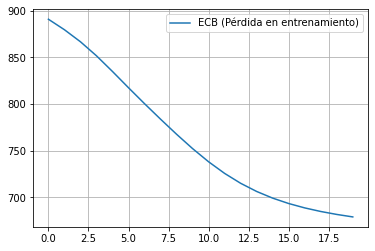

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(perdidas.size), perdidas, label='ECB (Pérdida en entrenamiento)')
plt.legend()
plt.grid(True)
plt.show()

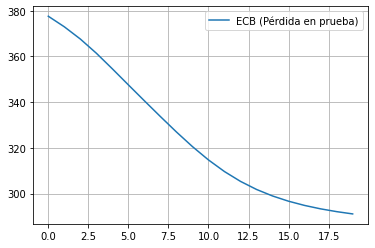

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(perdidas_test.size), perdidas_test, label='ECB (Pérdida en prueba)')
plt.legend()
plt.grid(True)
plt.show()

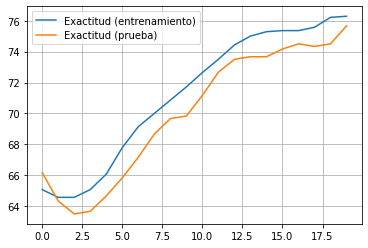

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud (entrenamiento)')
plt.plot(np.arange(exactitudes_test.size), exactitudes_test, label='Exactitud (prueba)')
plt.legend()
plt.grid(True)
plt.show()

## Entrenamiento modelando la XNOR

In [ ]:
X_xnor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xnor = np.array([[1], [0], [0], [1]])

In [ ]:
np.random.seed(0)
W1_xnor, W2_xnor, W3_xnor, b1_xnor, b2_xnor, b3_xnor, perdidas_xnor, exactitudes_xnor, _, _ = train(X_xnor, y_xnor,
                                                              alpha = 2.0, num_ocultas = 5, num_epocas = 100)

Número de ejemplos entrenamiento: 4
Número de entradas entrenamiento: 2
Epoch 0: Pérdida = 6.230187147122935 Exactitud = 50.0
Epoch 1: Pérdida = 5.055680539612569 Exactitud = 50.0
Epoch 2: Pérdida = 4.424486713842121 Exactitud = 50.0
Epoch 3: Pérdida = 4.192147147738835 Exactitud = 50.0
Epoch 4: Pérdida = 4.100650823190388 Exactitud = 50.0
Epoch 5: Pérdida = 4.060273776264857 Exactitud = 50.0
Epoch 6: Pérdida = 4.0376656807897735 Exactitud = 50.0
Epoch 7: Pérdida = 4.023081538061662 Exactitud = 50.0
Epoch 8: Pérdida = 4.012779611583079 Exactitud = 50.0
Epoch 9: Pérdida = 4.005006221104793 Exactitud = 50.0
Epoch 10: Pérdida = 3.9988207331601675 Exactitud = 50.0
Epoch 11: Pérdida = 3.993663240995274 Exactitud = 50.0
Epoch 12: Pérdida = 3.989166554262776 Exactitud = 50.0
Epoch 13: Pérdida = 3.9850615837101815 Exactitud = 50.0
Epoch 14: Pérdida = 3.9811210167588866 Exactitud = 50.0
Epoch 15: Pérdida = 3.977117908713982 Exactitud = 50.0
Epoch 16: Pérdida = 3.9727884100524262 Exactitud = 50.

## Resultados

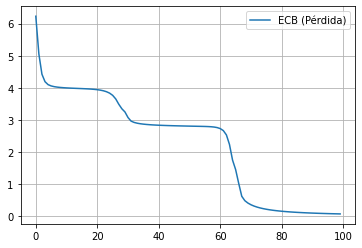

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(perdidas_xnor.size), perdidas_xnor, label='ECB (Pérdida)')
plt.legend()
plt.grid(True)
plt.show()

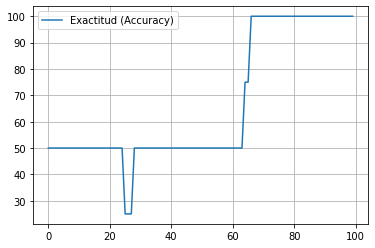

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(exactitudes_xnor.size), exactitudes_xnor, label='Exactitud (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

### Predicción

In [ ]:
X_t = np.array([0, 0])
_, _, _, _, _, y_hat = adelante(X_t, W1_xnor, b1_xnor, W2_xnor, b2_xnor, W3_xnor, b3_xnor)
print(f"XNOR 0,0 = {y_hat}")

X_t = np.array([0, 1])
_, _, _, _, _, y_hat = adelante(X_t, W1_xnor, b1_xnor, W2_xnor, b2_xnor, W3_xnor, b3_xnor)
print(f"XNOR 0,1 = {y_hat}")

X_t = np.array([1, 0])
_, _, _, _, _, y_hat = adelante(X_t, W1_xnor, b1_xnor, W2_xnor, b2_xnor, W3_xnor, b3_xnor)
print(f"XNOR 1,0 = {y_hat}")

X_t = np.array([1, 1])
_, _, _, _, _, y_hat = adelante(X_t, W1_xnor, b1_xnor, W2_xnor, b2_xnor, W3_xnor, b3_xnor)
print(f"XNOR 1,1 = {y_hat}")

XNOR 0,0 = [[0.98309375]]
XNOR 0,1 = [[0.01592462]]
XNOR 1,0 = [[0.01862354]]
XNOR 1,1 = [[0.98257963]]


**Conclusiones:** En el entrenamiento, con los datos de predicción de diabetes, la métrica de exactitud no fue la mejor, sin embargo, probablemente se deba a que las funciones de activación de la red neuronal están compuestas por funciones sigmoide, lo que provoca el desvanecimiento de los gradientes.  
  
Por otro lado, en el caso del entrenamiento para modelar la función XNOR, se puede notar que la pérdida disminuye lentamente, quizás porque se esté quedando en un punto silla y es hasta la época 63 que comienza a bajar la pérdida de manera considerable y la exactitud llega al 100. También se nota que una función simple, como el XNOR, en la red neuronal está tomando demasiadas épocas para llegar a una métrica aceptable, probablemente se deba a la función de activación saturada igualmente.
  
Finalmente, en cuanto a la retropropagación, esta mejora el rendimiento al entrenar, puesto que ahorra el volver a calcular las derivadas parciales. Por otro lado, para realizar el cálculo de los gradientes, con respecto a los pesos y sesgos, se empleó la regla de la cadena del cálculo ya que se tratan composiciones de funciones. Parece existir un patrón en dichas fórmulas que probablemente, con un mayor número de capas, se puedan inferir que fórmulas deberían emplearse.